In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [3]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis_2tight_1veto'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
    'MuonEG': fileset_2018['MuonEG'],
    'DoubleMuon': fileset_2018['DoubleMuon'],
    'EGamma': fileset_2018['EGamma'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/1057 [00:00<?, ?file/s]

Processing:   0%|          | 0/1059 [00:00<?, ?chunk/s]

/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/env

In [4]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma,S/B
entry,33.99 +/- 0.09,546.8 +/- 3.5,2267.0 +/- 4.0,612.5 +/- 1.4,34360.0 +/- 60.0,130300.0 +/- 100.0,385400.0 +/- 1200.0,543500.0 +/- 700.0,1016000.0 +/- 1000.0,300700.0 +/- 500.0,0.0000
filter,33.96 +/- 0.09,546.2 +/- 3.5,2264.0 +/- 4.0,611.9 +/- 1.4,34340.0 +/- 60.0,130200.0 +/- 100.0,385300.0 +/- 1200.0,543300.0 +/- 700.0,1016000.0 +/- 1000.0,300600.0 +/- 500.0,0.0000
lepveto,30.22 +/- 0.09,466.7 +/- 3.1,1919.0 +/- 3.0,493.3 +/- 1.3,33290.0 +/- 50.0,95340.0 +/- 120.0,335000.0 +/- 1200.0,376400.0 +/- 600.0,632000.0 +/- 800.0,255600.0 +/- 500.0,0.0000
trilep,19.45 +/- 0.07,277.5 +/- 2.1,1350.0 +/- 3.0,268.8 +/- 0.9,21800.0 +/- 40.0,38480.0 +/- 60.0,161900.0 +/- 800.0,72550.0 +/- 270.0,180400.0 +/- 400.0,60500.0 +/- 250.0,0.0000
p_T(lep0)>25,19.37 +/- 0.07,276.3 +/- 2.1,1347.0 +/- 3.0,266.4 +/- 0.9,21510.0 +/- 40.0,38070.0 +/- 60.0,159600.0 +/- 800.0,71280.0 +/- 270.0,175100.0 +/- 400.0,60300.0 +/- 250.0,0.0000
p_T(lep1)>20,18.85 +/- 0.07,268.9 +/- 2.0,1319.0 +/- 3.0,254.5 +/- 0.9,20720.0 +/- 40.0,35720.0 +/- 60.0,151700.0 +/- 800.0,67660.0 +/- 260.0,164200.0 +/- 400.0,57920.0 +/- 240.0,0.0000
trigger,18.36 +/- 0.07,261.1 +/- 2.0,1294.0 +/- 3.0,247.1 +/- 0.9,20240.0 +/- 40.0,34480.0 +/- 60.0,146500.0 +/- 800.0,20540.0 +/- 140.0,151700.0 +/- 400.0,34760.0 +/- 190.0,0.0000
offZ,16.3 +/- 0.06,230.7 +/- 1.9,281.2 +/- 1.3,212.6 +/- 0.8,4110.0 +/- 19.0,29890.0 +/- 60.0,28030.0 +/- 340.0,15520.0 +/- 120.0,40130.0 +/- 200.0,8987.0 +/- 95.0,0.0001
MET>50,13.47 +/- 0.06,185.6 +/- 1.7,195.5 +/- 1.1,168.0 +/- 0.7,2076.0 +/- 14.0,20740.0 +/- 50.0,3235.0 +/- 109.0,10080.0 +/- 100.0,13580.0 +/- 120.0,3172.0 +/- 56.0,0.0003
N_jet>2,12.46 +/- 0.06,138.6 +/- 1.5,169.4 +/- 1.0,145.9 +/- 0.7,518.4 +/- 7.1,12360.0 +/- 30.0,610.8 +/- 46.6,5770.0 +/- 76.0,6054.0 +/- 78.0,1474.0 +/- 38.0,0.0005


In [5]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9991,0.9991,0.9990,0.9989,0.9996,0.9997,0.9998,0.9996,0.9997,0.9995
lepveto,0.8898,0.8543,0.8476,0.8062,0.9694,0.7321,0.8694,0.6928,0.6222,0.8504
trilep,0.6438,0.5947,0.7036,0.5450,0.6547,0.4036,0.4832,0.1928,0.2855,0.2367
p_T(lep0)>25,0.9956,0.9957,0.9978,0.9911,0.9868,0.9895,0.9857,0.9825,0.9706,0.9966
p_T(lep1)>20,0.9733,0.9731,0.9788,0.9552,0.9631,0.9383,0.9503,0.9491,0.9373,0.9606
trigger,0.9738,0.9710,0.9812,0.9708,0.9769,0.9651,0.9663,0.3036,0.9243,0.6002
offZ,0.8877,0.8837,0.2173,0.8607,0.2030,0.8669,0.1913,0.7555,0.2645,0.2585
MET>50,0.8265,0.8044,0.6953,0.7900,0.5051,0.6938,0.1154,0.6498,0.3384,0.3530
N_jet>2,0.9250,0.7470,0.8664,0.8686,0.2497,0.5962,0.1888,0.5723,0.4457,0.4647


In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

Here are the graphs:

Data: 3965.0 MC: 4255.49


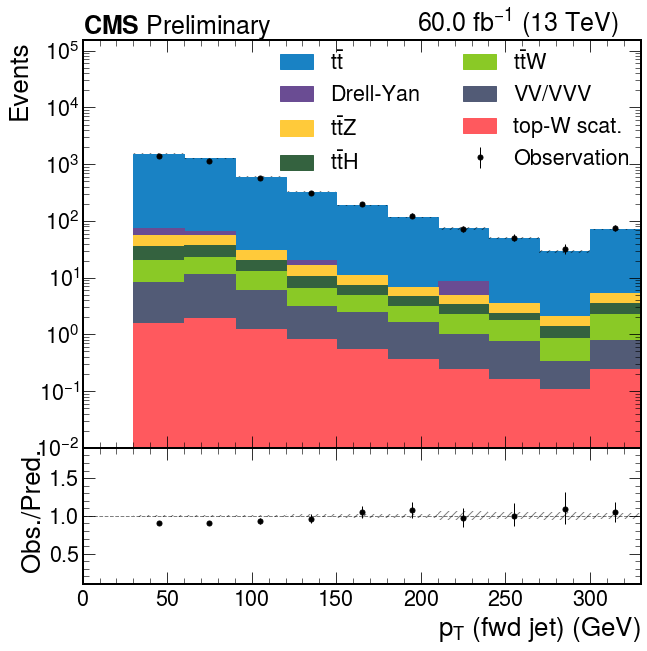

In [17]:
makePlot(output, 'fwd_jet', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (fwd jet) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


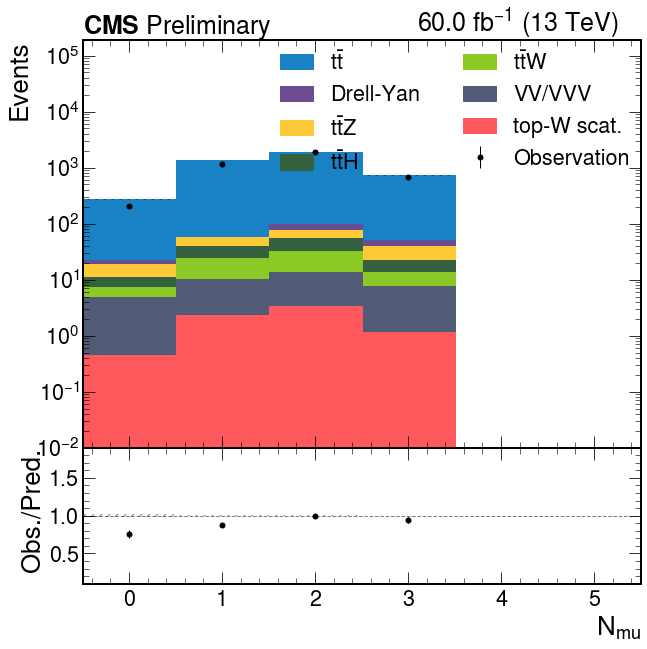

In [18]:
makePlot(output, 'N_mu', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{mu}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


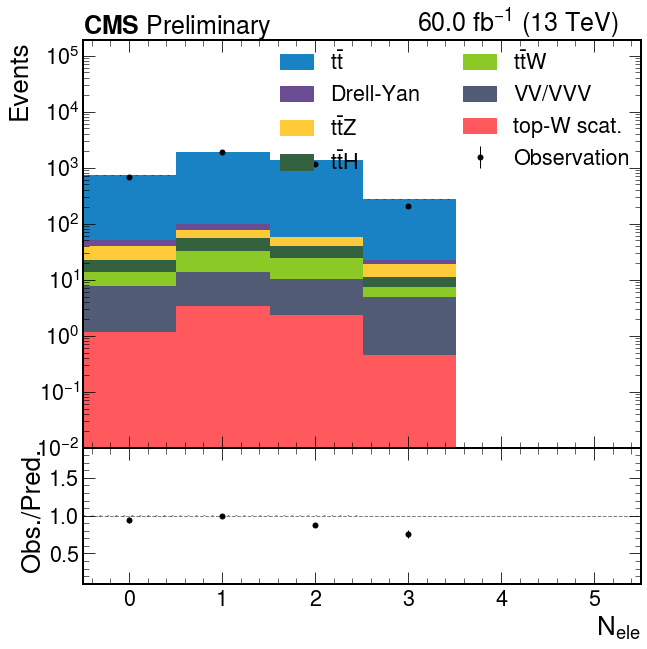

In [19]:
makePlot(output, 'N_ele', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{ele}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


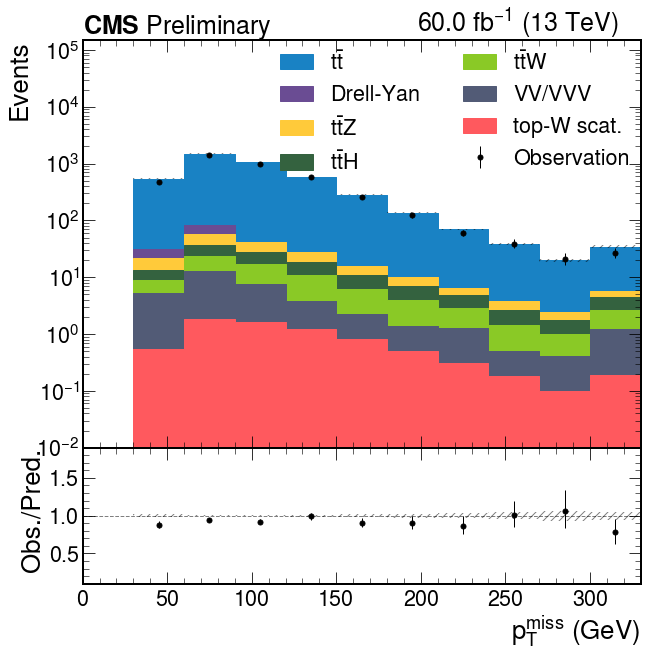

In [20]:
makePlot(output, 'MET', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}^{miss}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ','DY', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


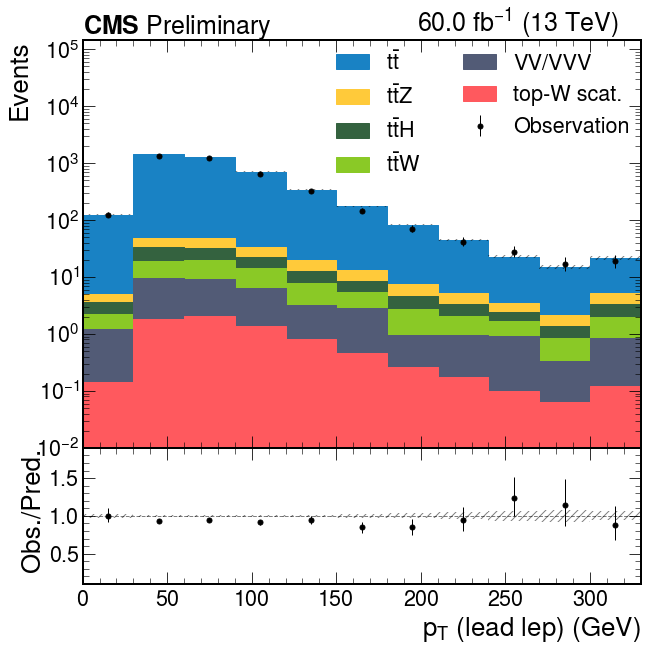

In [21]:
makePlot(output, 'lead_lep', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


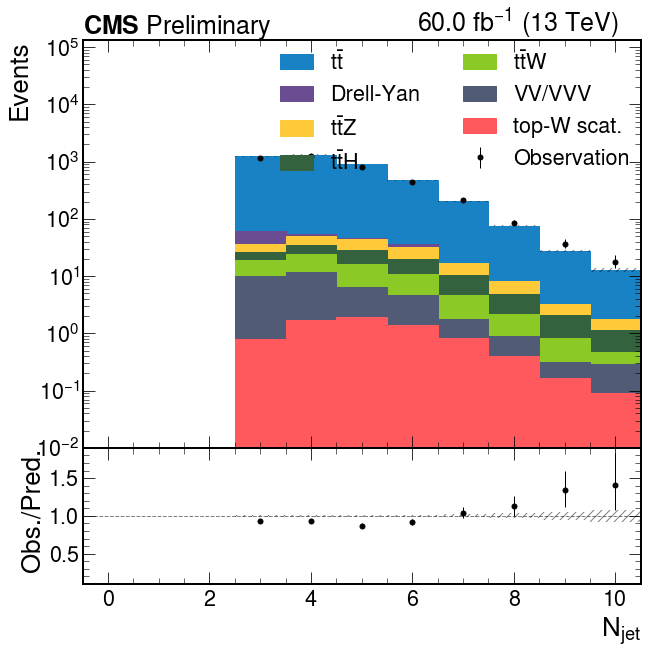

In [22]:
makePlot(output, 'N_jet', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins, log=True, normalize=False, axis_label=r'$N_{jet}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


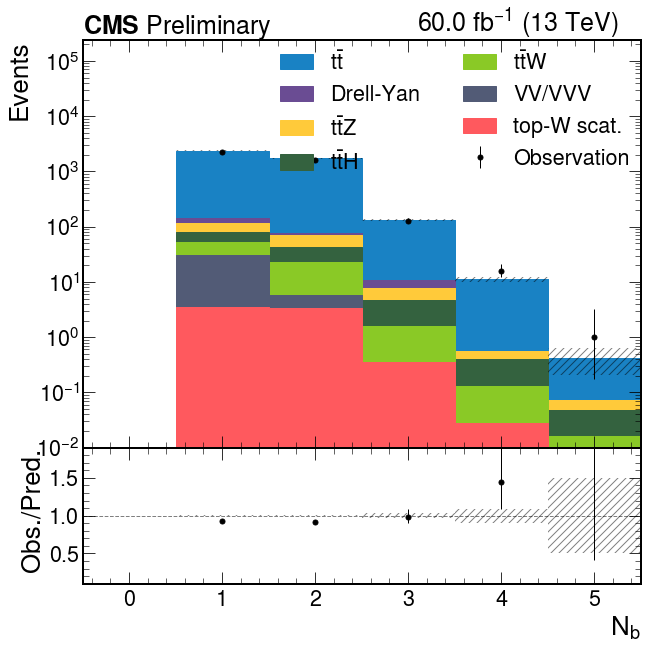

In [23]:
makePlot(output, 'N_b', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{b}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49


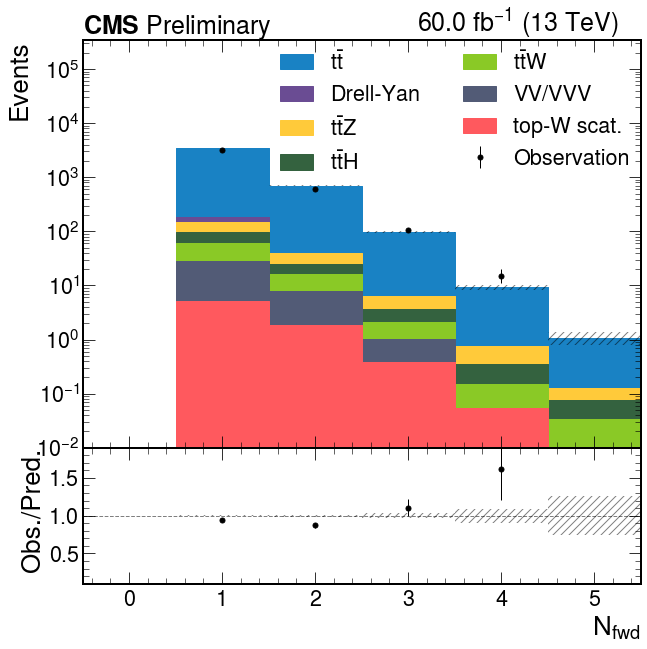

In [24]:
makePlot(output, 'N_fwd', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{fwd}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3185.0 MC: 3255.16


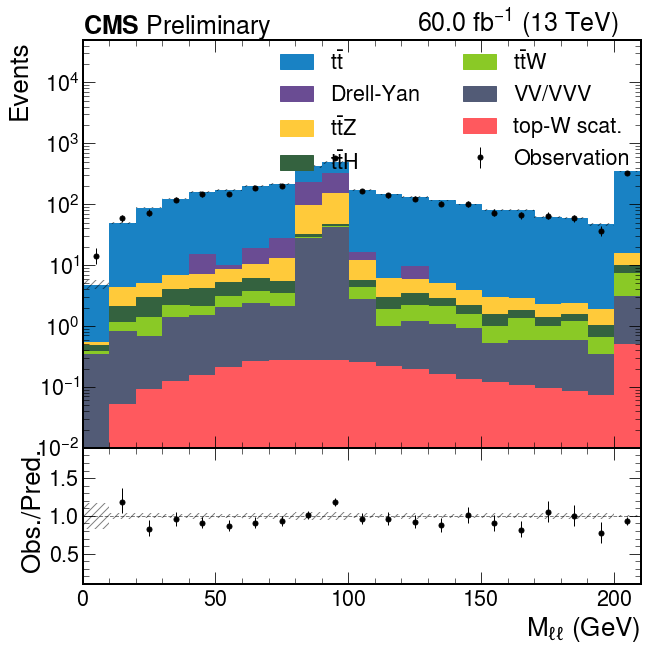

In [ ]:
makePlot(output, 'dilep_mass', 'mass',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=mass_bins, log=True, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'trail_lep', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3965.0 MC: 4255.49
